In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [4]:
data.shape

(13150, 10)

In [5]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## **Exercise 8.1**

Estimate a Decision Tree Classifier Manually using the code created in the decision trees notebook.

Evaluate the accuracy on the testing set

In [7]:
X.columns

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

## Predicting if salary is high with a decision tree
# Review - Building a Decision Tree by hand¶

In [8]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

For feature 1 calculate possible splitting points

In [9]:
j = 1
print(X.columns[j])

Mileage


In [10]:
# Split the variable in num_ctp points
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [11]:
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)

In [12]:
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

split the data using split 5

In [13]:
k = 5

In [14]:
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

**Gini**

The Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled if it was labeled by the distribution of samples in the node.

For each node

In [15]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [16]:
gini_l = gini(y_l)
gini_l

0.20562506325087826

In [17]:
gini_r = gini(y_r)
gini_r

0.3991431537249346

The gini impurity of the split is the Gini Impurity of each node is weighted by the fraction of points from the parent node in that node.

**putting all in a function**

In [18]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [19]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18496148274516044

**test all splits on all features**

In [20]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [21]:
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 2014.0, 0.23223870086324505)

In [22]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [23]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(13150, 4169, 8981)

In [24]:
y.mean(), y_l.mean(), y_r.mean()

(0.5795437262357415, 0.07939553849844087, 0.8117136176372342)

**Recursively grow the tree**

In [25]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [26]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': -1,
  'n_samples': 8368,
  'gain': 0.0359166442135464},
 'sr': {'y_pred': 0,
  'y_prob': 0.12771739130434784,
  'level': 1,
  'split': -1,
  'n_samples': 4782,
  'gain': 0.04846022210319853}}

In [27]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [28]:
tree

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 8368,
  'gain': 0.0359166442135464,
  'sl': {'y_pred': 0,
   'y_prob': 0.3403880070546737,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 565,
   'gain': 0.06001982703810749,
   'sl': {'y_pred': 0,
    'y_prob': 0.058823529411764705,
    'level': 3,
    'split': -1,
    'n_samples': 151,
    'gain': 0.005661757290357922},
   'sr': {'y_pred': 0,
    'y_prob': 0.44471153846153844,
    'level': 3,
    'split': -1,
    'n_samples': 414,
    'gain': 0.030742158715547196}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8737988468930173,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 7803,
   'gain': 0.015250286354762527,
   'sl': {'y_pred': 1,
    'y_prob': 0.731399157697707,
    'level': 3,
    'split': -1,
    'n_samples': 2135,
    'ga

In [29]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [39]:
tree_predict(X, tree)

array([1., 1., 0., ..., 1., 1., 0.])

## **Exercise 8.2**

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in bagging notebook.

Evaluate the accuracy on the testing set

In [74]:
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [75]:
# show the rows for the first decision tree
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
358005,2013,82246,1,0,0,0,0,0,0
137970,2016,38701,0,0,0,0,1,0,0
272337,2017,14302,0,0,0,0,0,1,0
354913,2017,35268,0,0,0,0,0,1,0
138402,2014,6455,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
110261,2014,22327,0,0,0,1,0,0,0
240532,2013,87215,0,0,0,0,0,0,1
305076,2015,24100,0,0,0,0,1,0,0
122421,2016,49095,0,0,0,0,0,1,0


## **Exercise 8.3**

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_features = 9)

In [73]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

C:\Users\meloj\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\meloj\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


(0.8688231792022227, 0.8476958525345623)

## **Exercise 8.4**

Estimate a Bagging of 10 Decision Tree Classifiers with max_features = log(n_features)

Evaluate the accuracy on the testing set

In [67]:
# Logaritmo de 10 es igual 1 y se reemplaza en el parametro Max_features
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_features = 1)

In [68]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

C:\Users\meloj\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\meloj\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


(0.8784243509400179, 0.8435483870967742)

## **Exercise 8.5**

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [33]:
# Muestra un accuracy del 0.833
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.833712
std       0.006449
min       0.821793
25%       0.829739
50%       0.834279
75%       0.839387
max       0.841090
dtype: float64

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
rf_predictions = clf.predict(X_test)


In [35]:
rf_predictions

array([0, 1, 1, ..., 1, 1, 0])

In [36]:
#Se calcula el accuracy del modelo donde nos arroja el 
from sklearn.metrics import accuracy_score
accuracy_score(y_test, rf_predictions)

0.838479262672811

## **Exercise 8.6**

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [37]:
#Tuning n_estimators
# list of values to try for n_estimators
estimator_range = range(10, 500, 20)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

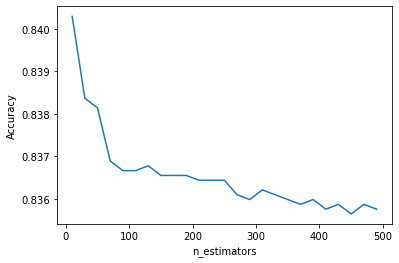

In [38]:
import matplotlib.pyplot as plt

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [44]:
#Tuning max_features
# list of values to try for max_features
feature_range = range(1, 10)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

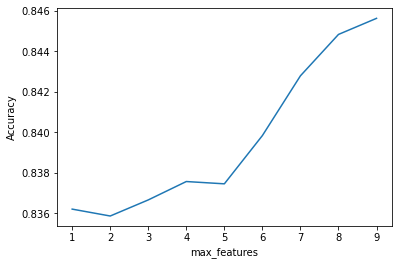

In [47]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [48]:
# max_features=9 is best and n_estimators=50 is sufficiently large
clf = RandomForestClassifier(n_estimators=50, max_features=9, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(max_features=9, n_estimators=50, n_jobs=-1,
                       random_state=1)

In [49]:
# Muestra un accuracy del 0.843, se observa una mejoria en el accuracy con respecto al modelo sin cross Validation
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.843814
std       0.007976
min       0.834279
25%       0.835698
50%       0.845630
75%       0.850170
max       0.853575
dtype: float64

## **Exercise 8.7**

Using xgboost train an XGBClassifier

Evaluate the accuracy on the testing set

In [51]:
conda install -c conda-forge xgboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\meloj\anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    conda-4.10.3               |   py38haa244fe_0         3.1 MB  conda-forge
    libxgboost-1.4.0           |       h0e60522_0         2.2 MB  conda-forge
    py-xgboost-1.4.0           |   py38haa244fe_0         141 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    xgboost-1.4.0              |   py38haa244fe_0          11 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.4 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/win-64::_py-xgboost-mutex



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [52]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [54]:
from sklearn import metrics
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

[22:19:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8989412897016361, 0.8790322580645161)


## **Exercise 8.8**

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
subsample, 

colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
    
Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

In [55]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

NameError: name 'xgb' is not defined

In [57]:
clf = XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1, gamma = 0.2)
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, gamma=0.2,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [58]:
from sklearn import metrics
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

[22:45:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\meloj\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\meloj\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8994285714285714, 0.8783410138248848)

El accuracy disminuyo cambiando los parametros learning rate, gamma, colsample_bytree